# Data processing: step 3

Make cuts on the events, define a signal region, split into train-test, preprocess

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from helpers.plotting import *


In [2]:
codes_list = ["od"]#, "zmm_forcms_1k-mz90.1-mw80.4_full"]#, "sim_zmm_forcms_1k-mz90.1-mw80.4_8000030"]

uncut_data = {}
for code in codes_list:
    uncut_data[code] = np.load(f"compiled_data/{code}.npy")
    
    uncut_data[code] = np.nan_to_num(uncut_data[code])
    
    print(f"{code} has initial shape {uncut_data[code].shape}")

od has initial shape (2245552, 9)


In [3]:
# plotting params

n_bins = 60

feature_bins = [
       np.linspace(0, 300, n_bins),
       np.linspace(-6, 6, n_bins),
       np.linspace(-3.2, 3.2, n_bins),
       np.linspace(20, 120, n_bins),
       np.linspace(0, 1, n_bins),
        np.linspace(0, 800, n_bins),
       np.linspace(-6, 6, n_bins),
       np.linspace(-3.2, 3.2, n_bins),
       np.linspace(20, 120, n_bins),]




kwargs_dict = {"od":  {"density": True, 
                       "histtype": "step", 
                       "color":"blue",
                       "label": "OD"},
               
              "zmm_forcms_1k-mz90.1-mw80.4_full":  {"density": True, 
                       "histtype": "step", 
                       "color":"red",
                       "label": "mZ=90"},
               
               "sim_wp_wzpythia_forcms_1k-mz50.0-mw40.0-mwp1000_8000199":  {"density": True, 
                       "histtype": "step", 
                       "color":"green",
                       "label": "mZ=50"},
               
               "sim_wp_wzpythia_forcms_1k-mz70.0-mw60.0-mwp1200_8000200":  {"density": True, 
                       "histtype": "step", 
                       "color":"orange",
                       "label": "mZ=70"},}

## Visualize the data

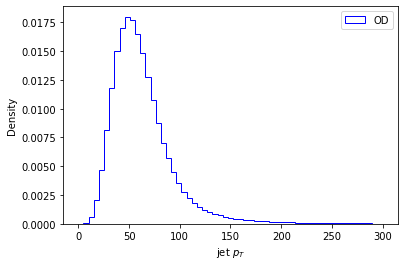

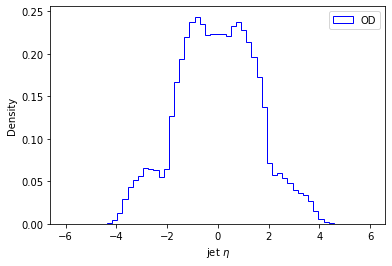

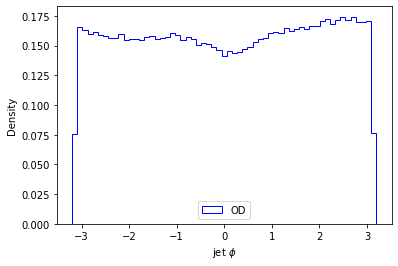

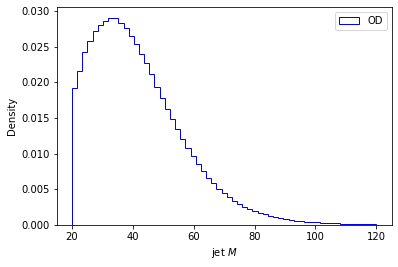

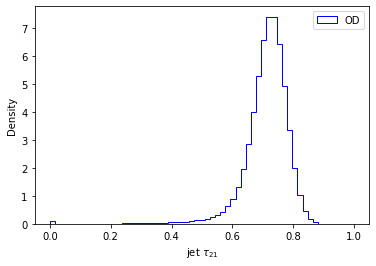

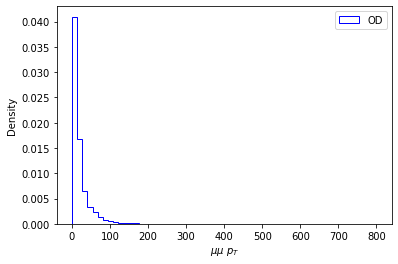

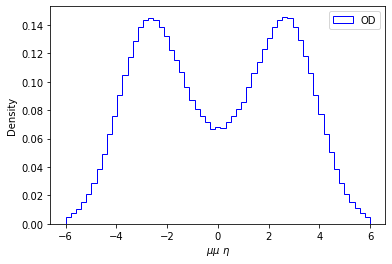

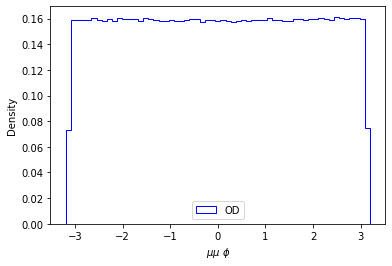

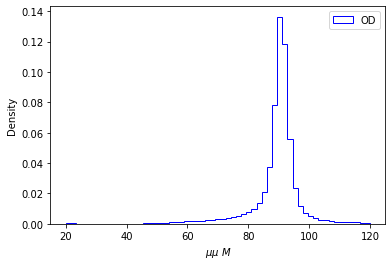

In [4]:
    
    
hist_all_features(codes_list, uncut_data, kwargs_dict, feature_bins)
    


## Make cuts

Now let's define cuts on the data. 

Muon cuts were made previously (and we don't want to make cuts on the dimuon system, either)

In [5]:
# jet_cuts

jet_pt_cut = 40
jet_eta_cut = 2.5

cut_data = {}
for code in codes_list:
    
    # pt_cut, eta cut on the jets
    pass_indices = (uncut_data[code][:,0] > jet_pt_cut) & (np.abs(uncut_data[code][:,1]) < jet_eta_cut)
    cut_data[code] = uncut_data[code][pass_indices]
    print(f"{code} has shape {cut_data[code].shape} after cuts")
    

    

od has shape (1596743, 9) after cuts


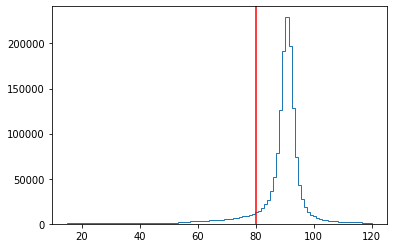

In [10]:
plt.figure()
plt.hist(cut_data[code][:,8], bins = np.linspace(15, 120, 100), histtype = "step")
plt.axvline(80, color= "red")
#plt.yscale("log")
plt.show()

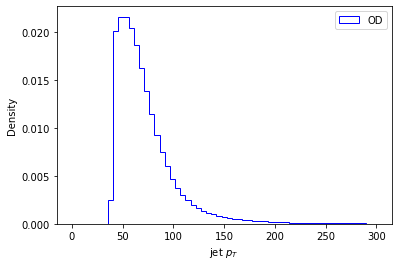

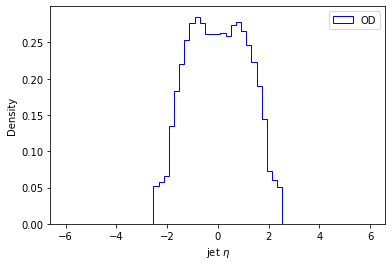

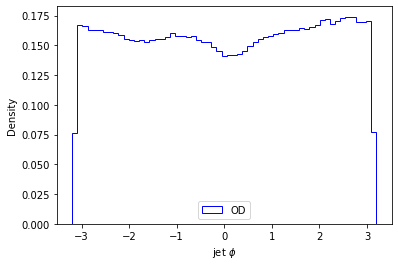

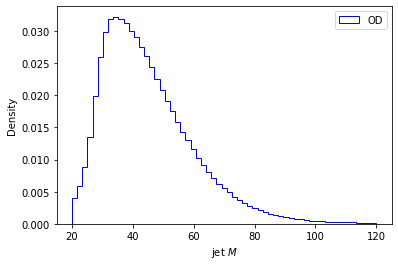

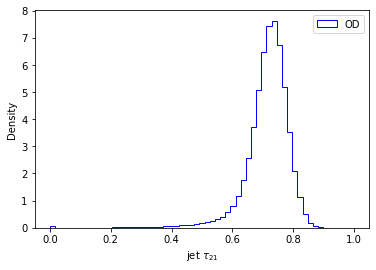

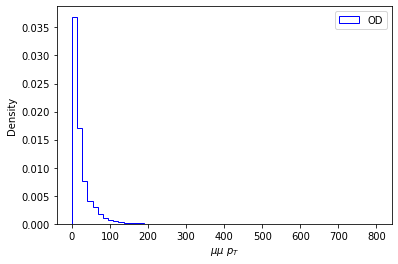

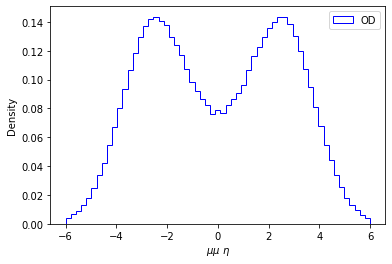

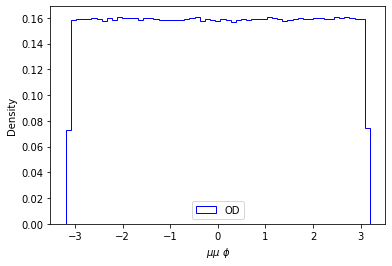

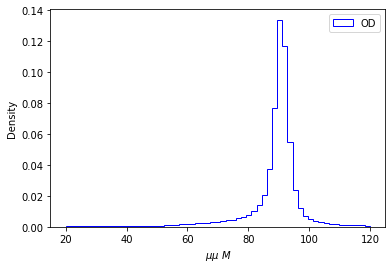

In [7]:
    
    
hist_all_features(codes_list, cut_data, kwargs_dict, feature_bins, image_path = "plots/sim_v_od")
    

## Define SR / SB

Signal region can be anywhere from 10 - 90 geV

In [11]:
SR_data_preprocc = {}
SBL_data_preprocc = {} # sideband low
SBH_data_preprocc = {} # sideband high
IBL_data_preprocc = {} # innerband low
IBH_data_preprocc = {} # innerband high

bands = ["SBL", "IBL", "SR", "IBH", "SBH"]

preproc_dicts = {b:{} for b in bands}

band_bounds = {"SBL": [15, 40],
               "IBL": [40, 45],
               "SR": [45, 65],
               "IBH": [65, 70],
               "SBH": [70, 80],
                       }

for code in codes_list:
    
    for b in bands:

        loc_pass_indices = (cut_data[code][:,-1] > band_bounds[b][0]) & (cut_data[code][:,-1] < band_bounds[b][1])
        preproc_dicts[b][code] = cut_data[code][loc_pass_indices]

        print(f"{code} {b} has shape {preproc_dicts[b][code].shape}")
   
    
    

od SBL has shape (9966, 9)
od IBL has shape (1720, 9)
od SR has shape (35708, 9)
od IBH has shape (20791, 9)
od SBH has shape (73378, 9)


In [ ]:
#hist_all_features(codes_list, SR_data_preprocc, kwargs_dict, feature_bins)
#hist_all_features(codes_list, SB1_data_preprocc, kwargs_dict, feature_bins)
#hist_all_features(codes_list, SB2_data_preprocc, kwargs_dict, feature_bins)

## Preprocessing

Standard scaling is fine

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

proc_dicts = {b:{} for b in bands}

for code in codes_list:
    
    SB_all = np.vstack((preproc_dicts["SBL"][code], preproc_dicts["SBH"][code]))
    scaler = MinMaxScaler(feature_range = (-3, 3))
    scaler = scaler.fit(SB_all)
    
    for b in bands:
    
        proc_dicts[b][code] = scaler.transform(preproc_dicts[b][code])


scaled_bins = [np.linspace(-3.5, 3.5, n_bins) for i in range(9)]

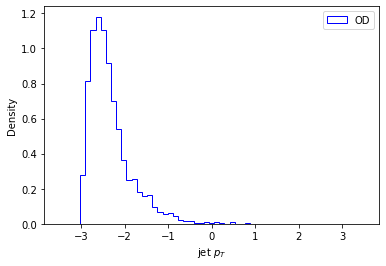

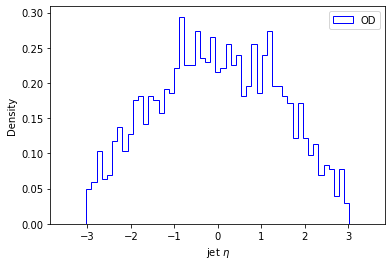

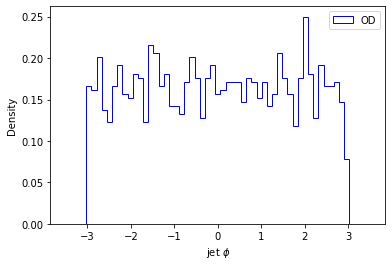

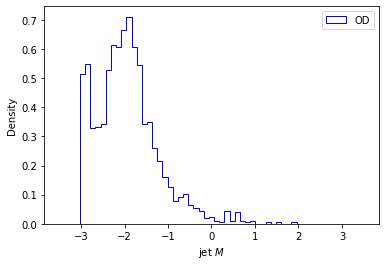

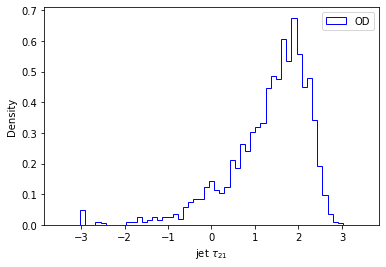

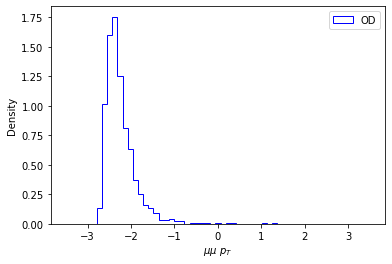

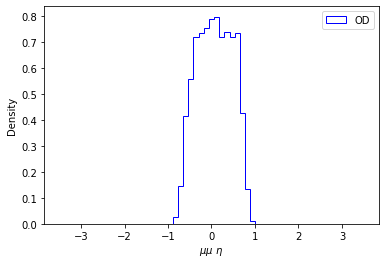

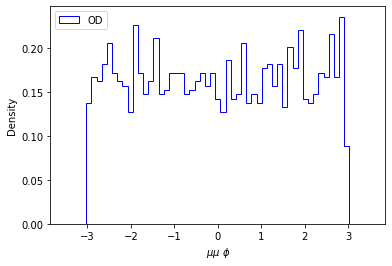

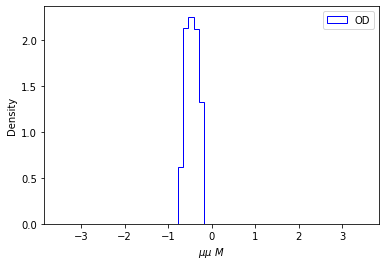

In [13]:
hist_all_features(codes_list, proc_dicts["IBL"], kwargs_dict, scaled_bins)


In [14]:
#hist_all_features(codes_list, SB_data_procc, kwargs_dict, scaled_bins)


In [15]:
for code in codes_list:

    for b in bands:
    
        np.save(f"processed_data/{code}_{b}_minmax.npy", proc_dicts[b][code])

